In [55]:
# Importing all necessary libraries
%load_ext autoreload
%autoreload 2

# internal packages
import os
from collections import Counter, OrderedDict

# external packages
import torch
import torchvision
import numpy as np
import sklearn
from sklearn.cluster import KMeans
from sklearn.metrics import normalized_mutual_info_score
from sklearn.decomposition import PCA
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# util functions
from util.util import *

# dataset functions
from dataset import load_util

# autoencoder
from models.autoencoder.conv_ae import ConvAE
from models.simclr.simclr import *
from models.simclr.transforms import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [4]:
print("Versions:")
print(f"torch: {torch.__version__}")
print(f"torchvision: {torchvision.__version__}")
print(f"numpy: {np.__version__}",)
print(f"scikit-learn: {sklearn.__version__}")

device = detect_device()
print("Using device: ", device)

Versions:
torch: 1.7.1
torchvision: 0.8.2
numpy: 1.19.4
scikit-learn: 0.24.0
Using device:  cpu


In [5]:
# specify learning params
batch_size = 264
learning_rate = 1e-3
epochs = 150

# training

train = True

# load datasets and create dataloaders
data, testdata = load_util.load_cifar('./data', download=True, for_model='SimCLR')
data_percent = 0.4

Files already downloaded and verified


### Clustering and PCA of the Random SimCLR model

In [7]:
def encode_batchwise(dataloader, model, device):
    """ Utility function for embedding the whole data set in a mini-batch fashion
    """
    embeddings = []
    labels = []
    for batch, blabels in dataloader:
        batch_data = batch.to(device)
        vec, proj = model(batch_data)
        embeddings.append(vec.detach().cpu())
        labels = labels + blabels.tolist()
    return torch.cat(embeddings, dim=0).numpy(), labels

In [8]:
test_data = load_util.load_custom_cifar('./data', download=False, train=False, data_percent=1.0)
testloader = torch.utils.data.DataLoader(test_data,
                                          batch_size=264,
                                          shuffle=True,
                                          drop_last=True)

In [9]:
colors_classes = {i: color_class for i, color_class in zip(range(len(test_data.classes)), test_data.classes)}

In [50]:
iterations = [100,200]
resnets = [18,50]
nmis = {}
pcas = {}

In [51]:
for iteration in iterations:
    for resnet in resnets:
        model = SimCLR(resnet_model=f'resnet{resnet}')

        state_dict = torch.load(f'trained_models/pretrained_SimCLR_r{resnet}_{iteration}.pth', map_location='cpu')
        model.load_state_dict(state_dict)
        ver = f'r{resnet} it{iteration}'

        print(f'SimCLR {ver}')
        print('Starting encoding...')
        embedded_data, labels = encode_batchwise(testloader, model, device)
        lable_classes=[colors_classes[l] for l in labels]

        print('Starting KMeans...')
        n_clusters = len(set(labels))
        kmeans = KMeans(n_clusters=n_clusters)
        kmeans.fit(embedded_data)
        nmi = normalized_mutual_info_score(labels, kmeans.labels_)
        nmis[ver] = nmi

        print('Starting PCA...')
        pca = PCA(n_components=2)
        reduced_data = pca.fit_transform(embedded_data)
        pcas[ver] = reduced_data

#         ax.set_title(f'SimCLR {ver} Kmeans NMI: {nmi:.4f}')
#         sns.scatterplot(x=reduced_data[:,0], y=reduced_data[:,1], hue=lable_classes, s=7, palette='viridis')

SimCLR r18 it100
Starting encoding...
Starting KMeans...
Starting PCA...
SimCLR r50 it100
Starting encoding...
Starting KMeans...
Starting PCA...
SimCLR r18 it200
Starting encoding...
Starting KMeans...
Starting PCA...
SimCLR r50 it200
Starting encoding...
Starting KMeans...
Starting PCA...


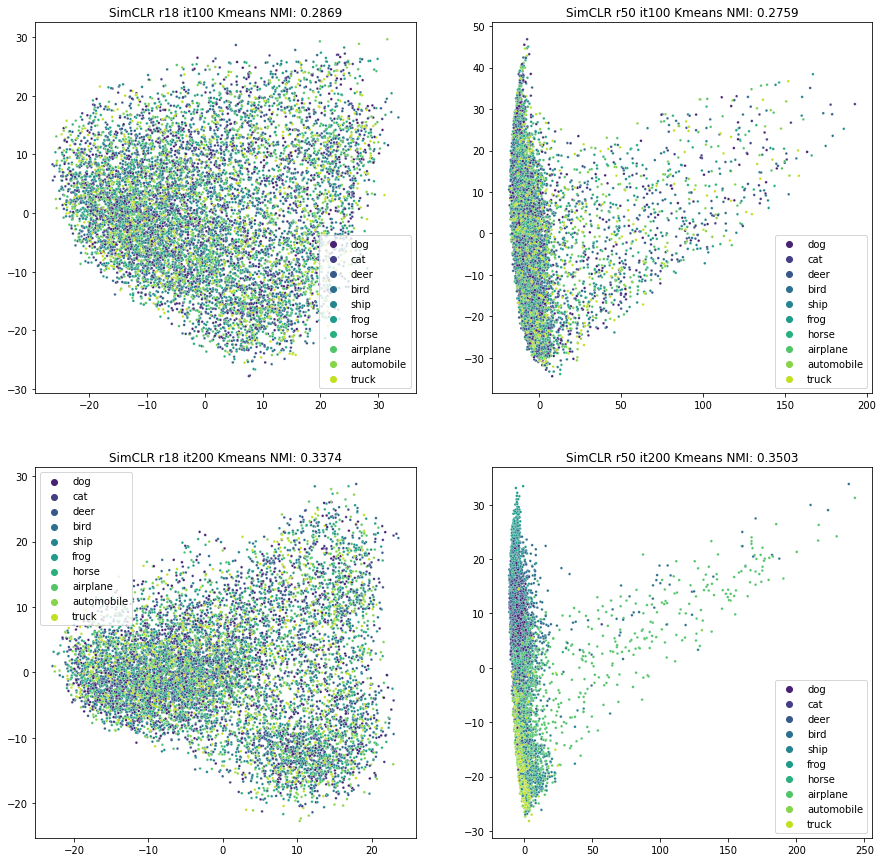

In [68]:
fig, axes = plt.subplots(2,2, figsize=(15,15))
axes = axes.flatten()

for i, ver in enumerate(nmis.keys()):
    axes[i].set_title(f'SimCLR {ver} Kmeans NMI: {nmis[ver]:.4f}')
    sns.scatterplot(ax=axes[i], x=pcas[ver][:,0], y=pcas[ver][:,1], hue=lable_classes, s=7, palette='viridis')  

### Loss statistics for epochs 100-200

In [103]:
iteration_r18 = pd.read_csv("stats/iteration_stat_r18_100.csv", delimiter=',')
iteration_r50 = pd.read_csv("stats/iteration_stat_r50_100.csv", delimiter=',')
iteration_r18['resnet'] = 'resnet18'
iteration_r50['resnet'] = 'resnet50'
iterations = pd.concat([iteration_r18, iteration_r50], ignore_index=True)

In [116]:
epochs_r18 = pd.read_csv("stats/epoch_stat_r18_100.csv", delimiter=',')
epochs_r50 = pd.read_csv("stats/epoch_stat_r50_100.csv", delimiter=',')
epochs_r18['resnet'] = 'resnet18'
epochs_r50['resnet'] = 'resnet50'

epochs_r18['mean'] = iteration_r18.groupby("epoch")["loss"].mean()
epochs_r50['mean'] = iteration_r50.groupby("epoch")["loss"].mean()

epochs = pd.concat([epochs_r18, epochs_r50], ignore_index=True)

In [104]:
def make_plots(df, x, y, hue, kind, figsize, title, ylim, nrows=1, ncolumns=2):
    fig, axes = plt.subplots(nrows,ncolumns,figsize=figsize)
    axes[0].set_title(title)
    sns.lineplot(ax=axes[0],data=df, x=x, y=y, hue=hue)
    axes[1].set_title(f'{title} (real scale)')
    sns.lineplot(ax=axes[1],data=df, x=x, y=y, hue=hue)
    axes[1].set(ylim=ylim)

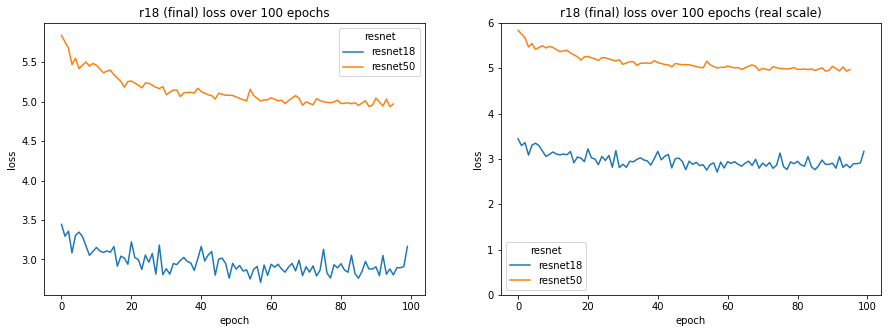

In [105]:
make_plots(df=epochs, x='epoch', y='loss', hue='resnet', kind='line', ylim=(0,6), figsize=(15,5),
           title='r18 (final) loss over 100 epochs')

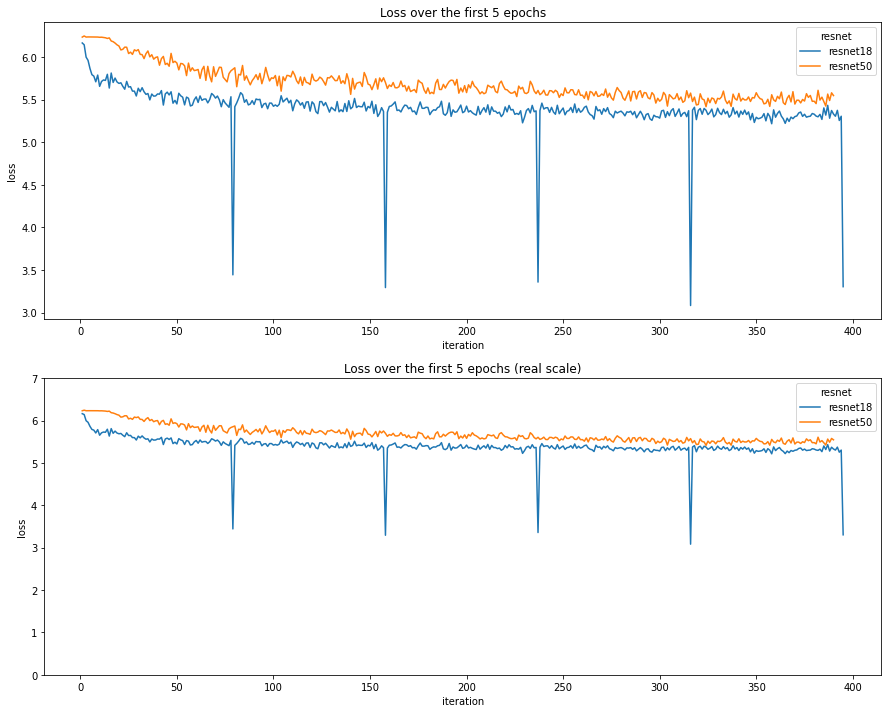

In [107]:
make_plots(df=iterations[iterations.epoch<5], x='iteration', y='loss', hue='resnet', kind='line',
           ylim=(0,7), figsize=(15,12),
           nrows=2, ncolumns=1, title='Loss over the first 5 epochs')

I took the old loss data for resnet18. As can be seen from the plot, after drop_last was set to True, the drops in the end of each epoch disappeared.

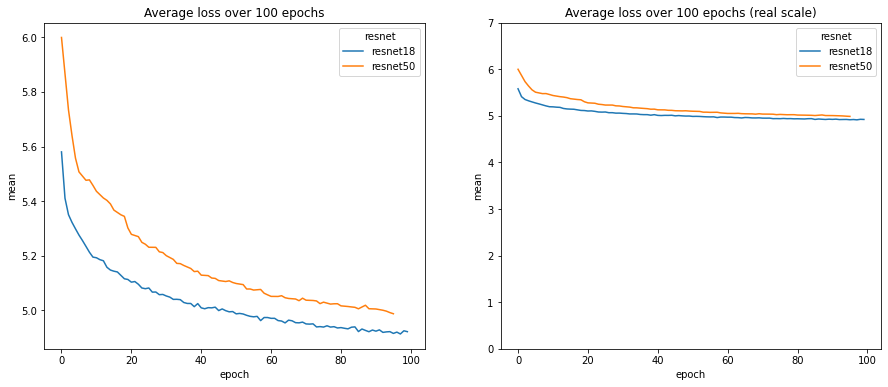

In [117]:
make_plots(df=epochs, x='epoch', y='mean', hue='resnet', kind='line', ylim=(0,7), figsize=(15,6),
           title='Average loss over 100 epochs')

### Plotting images from trainloader

In [31]:
data = load_util.load_custom_cifar('./data', download=True, for_model='SimCLR', data_percent=data_percent)
trainloader = torch.utils.data.DataLoader(data,
                                          batch_size=6,
                                          shuffle=True,
                                          drop_last=True)

Files already downloaded and verified


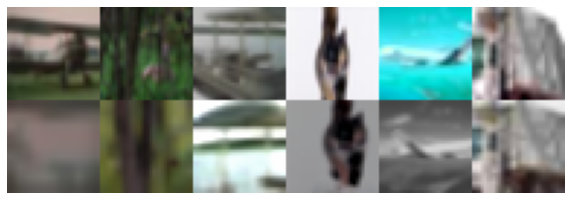

______________________________________________________________________


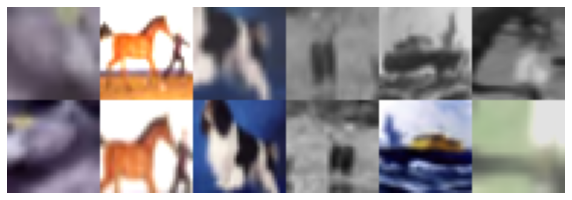

______________________________________________________________________


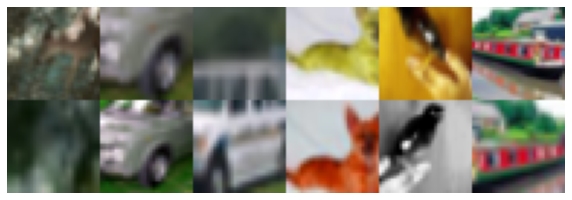

______________________________________________________________________


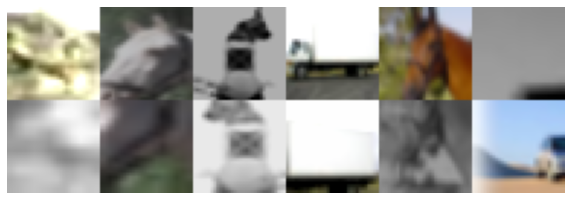

______________________________________________________________________


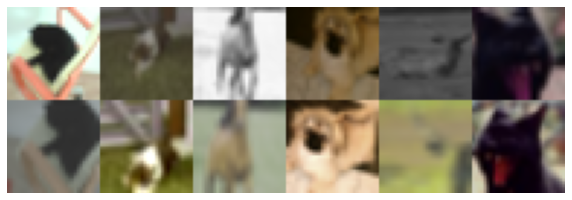

______________________________________________________________________


In [44]:
i = 1
for step, ((x_i, x_j), _) in enumerate(trainloader):
    x_ij = torch.cat((x_i,x_j),dim=0)
    plot_images(x_ij, nrow=6)
    print('______________________________________________________________________')
    
    i += 1
    if (i > 5):
        break